In [399]:
import os
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from tqdm.notebook import tqdm

In [400]:
#Load data from csv
data = pd.read_csv("combined_data/cleaned_data.csv")

#read the classes.npy
classes = np.load('combined_data/classes.npy', allow_pickle=True)
detailed_classes = np.load('combined_data/detailed_classes.npy', allow_pickle=True)


C:\Users\Rasmu\AppData\Local\Temp\ipykernel_26688\2394605343.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("combined_data/cleaned_data.csv")


             ts  id.orig_p  id.resp_p proto service    duration  orig_bytes  \
0  1.540469e+09      58687        123   udp     NaN    0.114184        48.0   
1  1.540469e+09       1900       1900   udp     NaN  160.367579      7536.0   
2  1.540469e+09      32893        123   udp     NaN    0.016986        48.0   
3  1.540470e+09      53395        443   tcp     NaN    0.003497         0.0   
4  1.540470e+09      52801         53   udp     dns    0.036724        34.0   

   resp_bytes conn_state  missed_bytes history  orig_pkts  orig_ip_bytes  \
0        48.0         SF             0      Dd          1             76   
1         0.0         S0             0       D         24           8208   
2        48.0         SF             0      Dd          1             76   
3         0.0         SF             0   ShAFf          5            212   
4       311.0         SF             0      Dd          1             62   

   resp_pkts  resp_ip_bytes  label  detailed_label  
0          1   

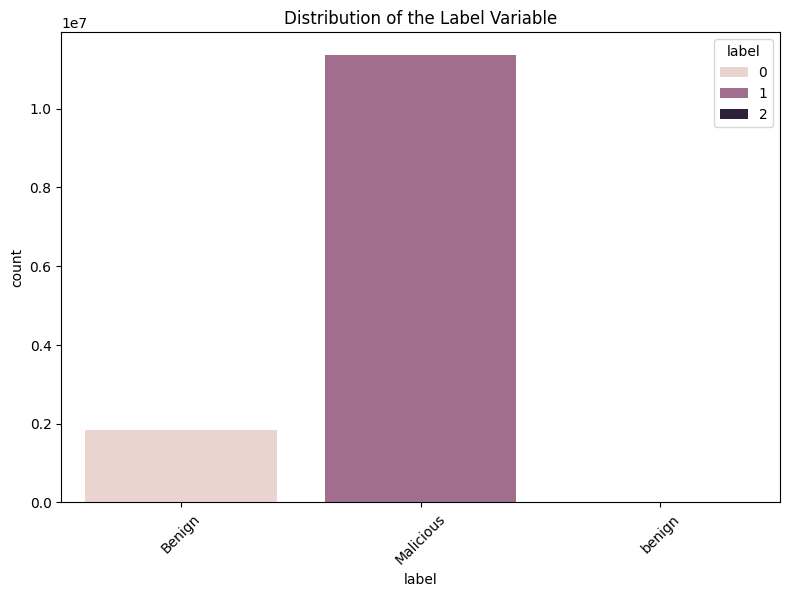

In [401]:
#Basic information about the data
print(data.head())
print(data.info())

# Plotting the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="label", hue="label")
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45)
plt.tight_layout()
plt.title("Distribution of the Label Variable")
plt.show()




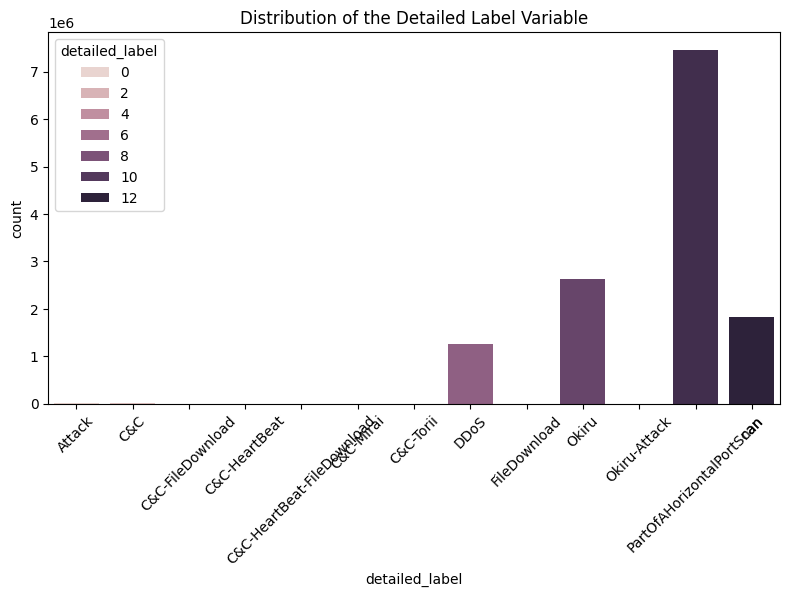

In [402]:
# Plotting the distribution of the target variable with detailed labels
plt.figure(figsize=(8, 6))
sns.countplot(data = data, x ='detailed_label', hue='detailed_label')
plt.xticks(ticks=np.arange(len(detailed_classes)), labels=detailed_classes, rotation=45)
plt.tight_layout()
plt.title("Distribution of the Detailed Label Variable")
plt.show()

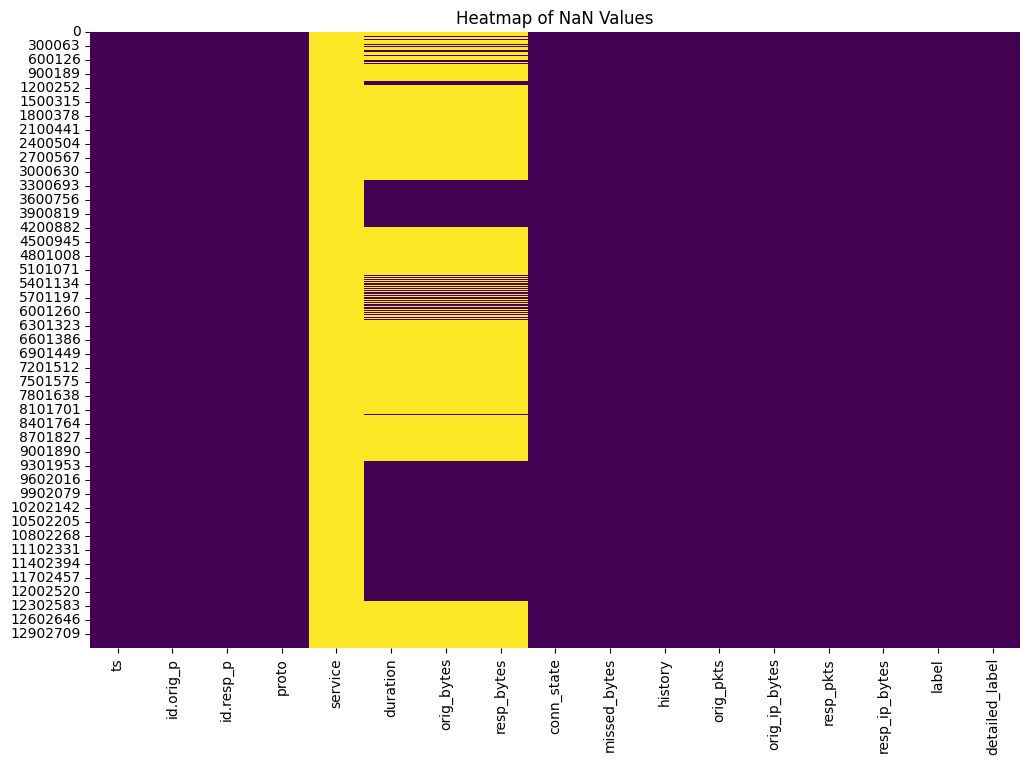

In [403]:
#I cannot use PCA on NaN values, so here look at a heatmap of NaN values
nan_matrix = data.isnull()
plt.figure(figsize=(12, 8))
sns.heatmap(nan_matrix, cbar=False, cmap='viridis')
plt.title('Heatmap of NaN Values')
plt.show()

Index(['ts', 'id.orig_p', 'id.resp_p', 'duration', 'orig_bytes', 'resp_bytes',
       'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts',
       'resp_ip_bytes', 'label', 'detailed_label'],
      dtype='object')


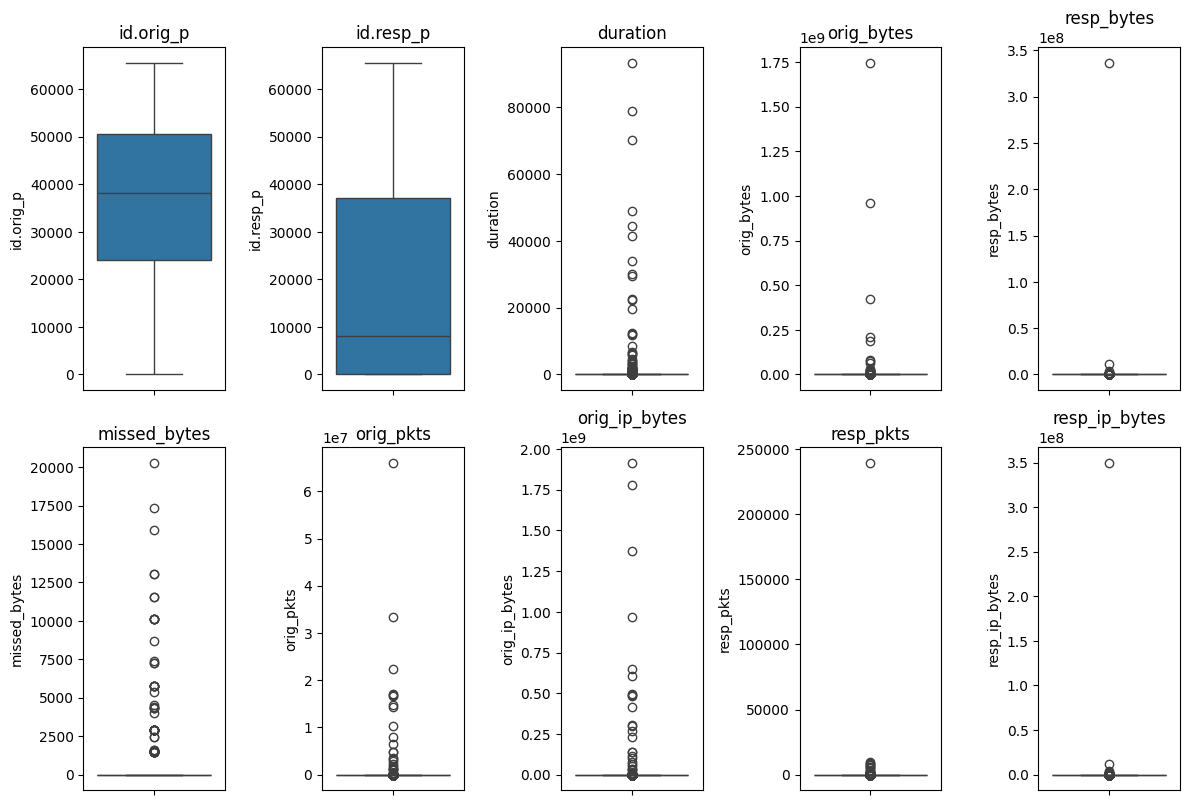

In [404]:
#Outliers

numerical_columns = data.select_dtypes(include=[np.number]).columns
print(numerical_columns)
numerical_columns = numerical_columns.drop(['ts','label', 'detailed_label'])

#A 2X5 grid of boxplots for numerical columns
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_columns):
    plt.subplot(2, 5, i+1)
    sns.boxplot(data[column])
    plt.title(column)
plt.tight_layout()
plt.show()


In [405]:
#Dealing with outliers
#As the boxplots show, there are outliers in the data. I will use the IQR method to remove them. Although all of the numerical columns have outliers, I will only remove outliers from duration.
outliers_columns = ['duration']
for col_name in outliers_columns:
    q1, q3 = np.nanpercentile(data[col_name],[25,75])
    intr_qr = q3-q1
    iqr_min_val = q1-(1.5*intr_qr)
    iqr_max_val = q3+(1.5*intr_qr)
    print(f"(min,max) bounds for \"{col_name}\": ({iqr_min_val},{iqr_max_val})")
    data.loc[data[col_name] < iqr_min_val, col_name] = np.nan
    data.loc[data[col_name] > iqr_max_val, col_name] = np.nan

(min,max) bounds for "duration": (-4.497802,7.496342)


In [406]:
#Check if the dataset have the same amount of columns
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13202765 entries, 0 to 13202764
Data columns (total 17 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ts              float64
 1   id.orig_p       int64  
 2   id.resp_p       int64  
 3   proto           object 
 4   service         object 
 5   duration        float64
 6   orig_bytes      float64
 7   resp_bytes      float64
 8   conn_state      object 
 9   missed_bytes    int64  
 10  history         object 
 11  orig_pkts       int64  
 12  orig_ip_bytes   int64  
 13  resp_pkts       int64  
 14  resp_ip_bytes   int64  
 15  label           int64  
 16  detailed_label  int64  
dtypes: float64(4), int64(9), object(4)
memory usage: 1.7+ GB
None


In [407]:
#Standardize numerical columns
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [408]:
#Use one hot encoding for the remaining categorical columns
# Columns to one-hot encode
columns_to_encode = ["proto", "service", "conn_state", "history"]

# Define chunk size (adjust based on available RAM)
chunk_size = 10**6  # Process 1 million rows at a time

# Calculate the total number of chunks
total_chunks = (len(data) // chunk_size) + 1

# Initialize an empty list to store processed chunks
chunk_list = []

# Process the data in chunks with a progress bar
for start in tqdm(range(0, len(data), chunk_size), total=total_chunks, desc="Processing Chunks"):
    # Extract chunk
    chunk = data.iloc[start:start + chunk_size]
    
    # Apply one-hot encoding on this chunk
    chunk_encoded = pd.get_dummies(chunk, columns=columns_to_encode, drop_first=False)
    
    # Optional: Convert to sparse format to save memory
    for col in chunk_encoded.columns:
        if col.startswith(tuple(columns_to_encode)):
            chunk_encoded[col] = chunk_encoded[col].astype(pd.SparseDtype("int", 0))
    
    # Append the processed chunk to the list
    chunk_list.append(chunk_encoded)

# Concatenate all processed chunks into a single dataframe
data = pd.concat(chunk_list, axis=0)

data

Processing Chunks:   0%|          | 0/14 [00:00<?, ?it/s]

MemoryError: Unable to allocate 7.63 MiB for an array with shape (1000000, 1) and data type int64

In [395]:
impute_columns = data.columns[data.isnull().any()]
# Step 1: Downcast numerical columns to save memory
def downcast(df):
    for col in df.select_dtypes(include=['float', 'int']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

data.loc[:, impute_columns] = downcast(data[impute_columns])

# Step 2: Apply KNN Imputer in chunks with progress bar
def knn_impute_in_chunks(data, impute_columns, chunk_size=10000, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    data_imputed_list = []
    
    # Create progress bar
    for i in tqdm(range(0, len(data), chunk_size), desc="Imputing data", unit="chunk"):
        chunk = data.iloc[i:i + chunk_size]

        # Select the columns to impute and ensure chunk has correct shape
        chunk_to_impute = chunk[impute_columns]

        # Apply imputer only on columns with missing values (avoid dropped columns)
        chunk_imputed = imputer.fit_transform(chunk_to_impute)

        # Append the imputed chunk back as a DataFrame
        data_imputed_list.append(pd.DataFrame(chunk_imputed, columns=impute_columns, index=chunk.index))
    
    return pd.concat(data_imputed_list, axis=0)

# Apply the function and monitor progress
data.loc[:, impute_columns] = knn_impute_in_chunks(data, impute_columns)

data.shape

C:\Users\Rasmu\AppData\Local\Temp\ipykernel_26688\2687036896.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], downcast='float')
C:\Users\Rasmu\AppData\Local\Temp\ipykernel_26688\2687036896.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], downcast='float')
C:\Users\Rasmu\AppData\Local\Temp\ipykernel_26688\2687036896.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Imputing data:   0%|          | 0/3 [00:00<?, ?chunk/s]

(23145, 51)

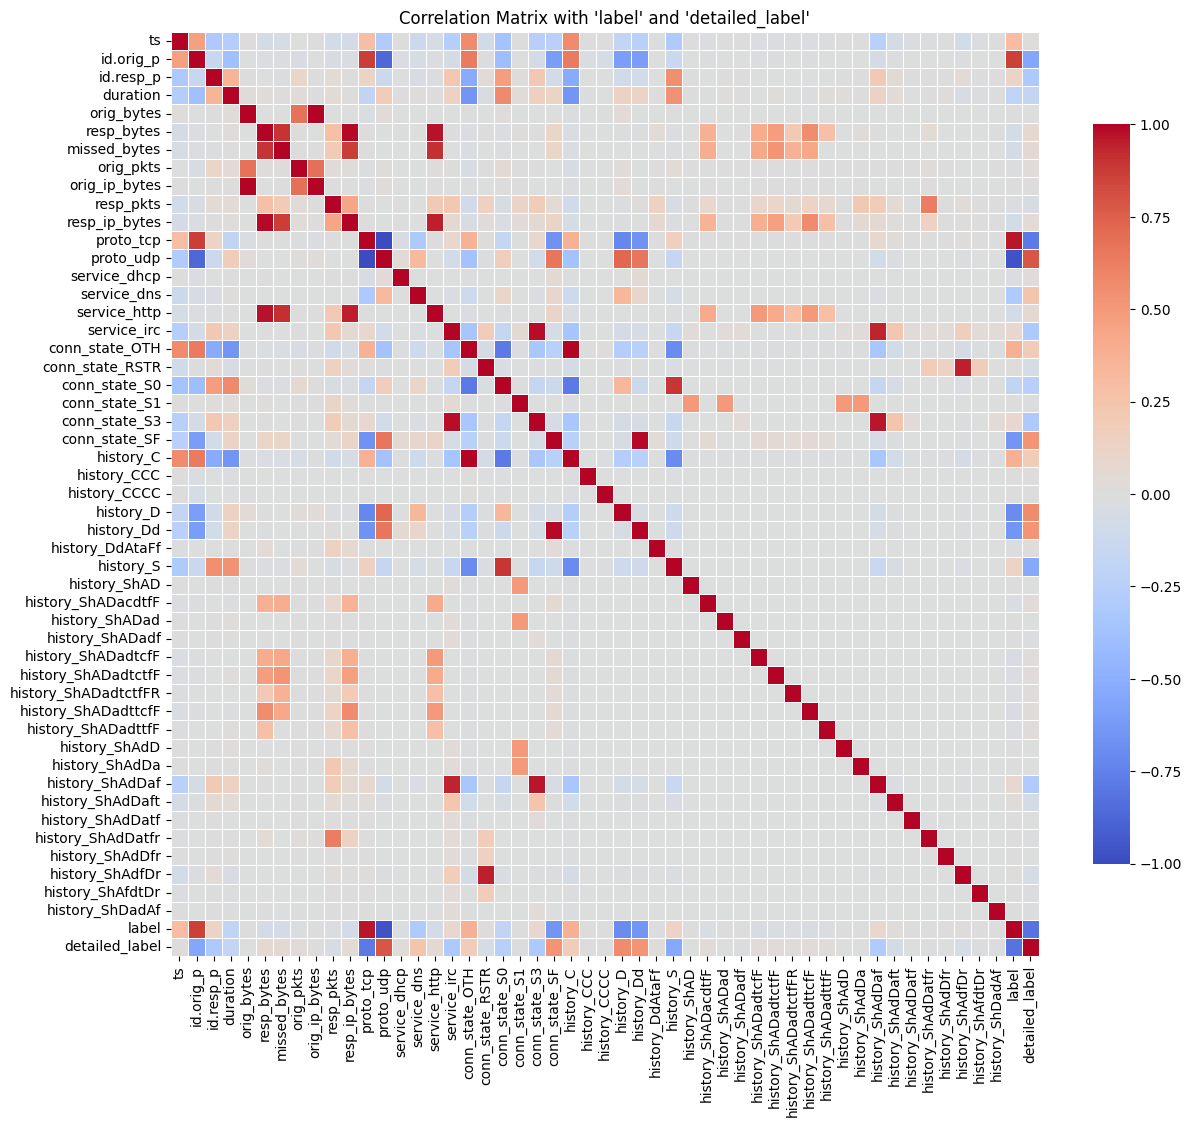

orig_ip_bytes        0.001861
history_ShAdDa       0.001979
history_ShADad       0.001979
history_ShAdD        0.001979
history_ShAD         0.001979
history_ShAdDfr      0.001979
history_ShAdDatf     0.001979
orig_bytes           0.002043
history_CCC          0.002798
history_ShADadf      0.002798
history_ShAdDatfr    0.002798
history_ShDadAf      0.002798
history_ShAfdtDr     0.002798
conn_state_S1        0.003958
history_CCCC         0.004847
orig_pkts            0.011175
history_ShAdfDr      0.013723
conn_state_RSTR      0.014421
resp_pkts            0.017452
history_ShAdDaft     0.020028
Name: label, dtype: float64


In [396]:
# Find the correlation matrix for the entire dataset
corr_matrix = data.corr()

# Ensure both 'label' and 'detailed_label' are at the end of the matrix
# Reorder columns to have 'label' and 'detailed_label' as the last two columns
ordered_columns = [col for col in corr_matrix.columns if col not in ['label', 'detailed_label']] + ['label', 'detailed_label']

# Create the correlation matrix with 'label' and 'detailed_label' as last two columns
corr_matrix_reordered = corr_matrix[ordered_columns].loc[ordered_columns]

# Plot correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_reordered, cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix with 'label' and 'detailed_label'")
plt.show()


#The 20 least correlated features
least_correlated_features = corr_matrix_reordered['label'].abs().sort_values().head(20)
print(least_correlated_features)


c:\Users\Rasmu\anaconda3\envs\network_traffic\lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


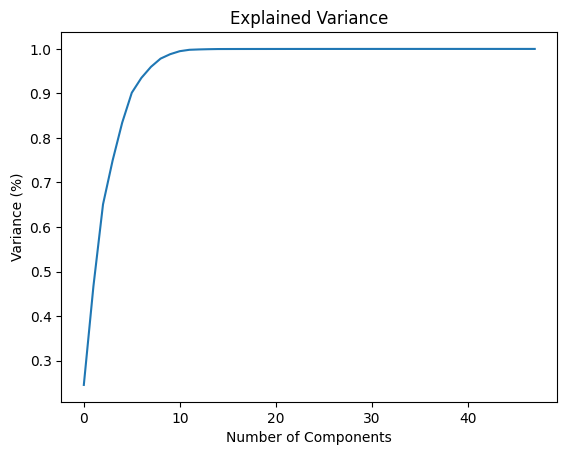

history_ShAD            0.000010
history_ShAdDatf        0.000015
history_ShADad          0.000017
history_ShAfdtDr        0.000019
history_ShAdD           0.000021
history_ShAdDfr         0.000021
history_ShADadf         0.000031
history_ShDadAf         0.000034
history_CCC             0.000056
service_dhcp            0.000080
history_CCCC            0.000178
history_ShADadttfF      0.000206
history_DdAtaFf         0.000276
history_ShAdDa          0.000425
history_ShAdfDr         0.000453
conn_state_S1           0.000464
history_ShADadtctfFR    0.000500
history_ShADacdtfF      0.000858
history_ShADadtctfF     0.001135
history_ShADadtcfF      0.001143
history_ShADadttcfF     0.001292
history_ShAdDatfr       0.001654
history_ShAdDaft        0.001702
conn_state_RSTR         0.002141
service_dns             0.002933
service_http            0.005085
history_ShAdDaf         0.026472
conn_state_S3           0.028255
service_irc             0.030841
conn_state_SF           0.033019
history_Dd

c:\Users\Rasmu\anaconda3\envs\network_traffic\lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [397]:
#Before i do PCA i seperate the data into the features and the target
X = data.drop(['ts', 'label', 'detailed_label'], axis=1)
y = data['label']

#Eigenvalue plot, with eigenvalues on the y-axis and the components on the x-axis
pca = PCA()
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

#Find the loading of each feature for the first 5 components
pca = PCA(n_components=5)
pca.fit(X)
loadings = pca.components_
loadings = pd.DataFrame(loadings, columns=X.columns)
#For each feature, find the absolute sum of the loadings
loadings = (loadings.abs().sum())/5

#Average loading
lowest_loading_features = loadings.sort_values().head(51)
print(lowest_loading_features)






In [398]:
#Since orig_bytes both have low correlation with the label and detailed_label and low loadings from the PCA analysis, I will remove them from the data 
data = data.drop(['orig_bytes'], axis=1)
data


,ts,id.orig_p,id.resp_p,duration,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,...,history_ShAdD,history_ShAdDa,history_ShAdDaf,history_ShAdDaft,history_ShAdDatf,history_ShAdDatfr,history_ShAdDfr,history_ShAdfDr,history_ShAfdtDr,history_ShDadAf
0,1.545404e+09,-0.894822,-0.418544,0.360916,-0.065163,-0.020755,-0.018904,-0.006964,-0.073566,-0.040994,...,0,0,0,0,0,0,0,0,0,0
1,1.545404e+09,-0.894822,-0.418544,-0.113361,0.016797,-0.020755,-0.030105,-0.007203,-0.073566,-0.040994,...,0,0,0,0,0,0,0,0,0,0
2,1.545404e+09,-0.894822,-0.418544,-0.113361,0.016797,-0.020755,-0.030105,-0.007203,-0.073566,-0.040994,...,0,0,0,0,0,0,0,0,0,0
3,1.545404e+09,-0.894822,-0.418544,-1.699273,23.783440,28.236054,0.490772,0.003719,11.484735,51.209562,...,0,0,0,0,0,0,0,0,0,0
4,1.545404e+09,-0.894705,-0.418544,0.370718,-0.065163,-0.020755,-0.018904,-0.006964,-0.073566,-0.040994,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,1.545490e+09,0.040774,0.809728,0.073497,-0.015142,-0.020755,0.003500,-0.006456,0.648828,0.176106,...,0,0,1,0,0,0,0,0,0,0
23141,1.545490e+09,0.039726,0.809728,1.032404,-0.016815,-0.020755,0.020302,-0.006112,0.769227,0.191956,...,0,0,1,0,0,0,0,0,0,0
23142,1.545490e+09,-3.277010,-0.410526,0.338689,-0.047376,-0.020755,-0.030105,-0.007171,-0.073566,-0.040994,...,0,0,0,0,0,0,0,0,0,0
23143,1.545490e+09,-3.277010,-0.410526,0.338689,-0.047376,-0.020755,-0.030105,-0.007171,-0.073566,-0.040994,...,0,0,0,0,0,0,0,0,0,0
